In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import sys,os,glob
print('Python version:',sys.version)
print('Conda environment:',os.environ['CONDA_DEFAULT_ENV'])
import numpy as np
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# from mpl_toolkits.basemap import Basemap
import xarray as xr
print("version of xarray:",xr.__version__)
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(8))
import pickle
from pprint import pprint
from scipy.optimize import minimize

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
repodir = workdir
while os.path.basename(repodir) != 'aggregation-and-extreme-rain':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from scalingApproximations import *
from plot1DInvLog import *
from dataFormat import *
from importingData import *
from savingResults import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Python version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Conda environment: pyPhD
version of xarray: 0.10.8
repo: /global/cscratch1/sd/bfildier/dataAnalysis/aggregation-and-extreme-rain
Own modules available: ['thermoConstants', 'setEnv', 'thermoFunctions', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'dataFormat', 'savingResults', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'slicingAndSubsetting', 'thermoFunctionsForMoistAdiabat', 'plot2D']


In [3]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

In [4]:
states = 'cold','warm'
# SSTs = 300,304
# SSTs = 300,302
# SSTs = 302,304
# SSTs = 304,306
SSTs = 306,308

reals = 1,1
# reals = 2,1

case = 'RCE'
Nxyz = '256x256x64'
Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
simroot = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_%s"%Nxyz
# Experiment name
expname_pattern = "TKE-SST%d-r%d"
# expname_pattern = "TKE-SST%d-radhomo-r%d"
# expname_pattern = "TKE-SST%d-r%d-b150-sfcagg"
# expname_pattern = "TKE-SST%d-r%d-b150-sfcdisagg"
# expname_pattern = "TKE-SST%d-radhomo-r%d-b100-radagg"
expnames = {}
simnames = {}
for SST,r in zip(SSTs,reals):
    expnames[SST] = expname_pattern%(SST,r)
    simnames[SST] = "%s_%s"%(simroot,expnames[SST])
    
print("Simulation names:",simnames[SSTs[0]],'\n',simnames[SSTs[1]])


Simulation names: RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1 
 RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r1


In [5]:
figdir = os.path.join(figuredir,simroot,"%s_%s"%(expnames[SSTs[0]],expnames[SSTs[1]]))
if not os.path.exists(figdir): os.makedirs(figdir)

resdir = {}
for SST in SSTs:
    resdir[SST] = os.path.join(resultdir,simroot,expnames[SST])

In [6]:
figsubdir_contributions = os.path.join(figdir,'dynamic_thermo_contributions')
if not os.path.exists(figsubdir_contributions): os.makedirs(figsubdir_contributions)

ressubdir_contributions = {}
for SST in SSTs:
    ressubdir_contributions[SST] = os.path.join(resdir[SST],'dynamic_thermo_contributions')

In [7]:
resultdir4saving = os.path.join(resultdir,'dynamic_thermo_contributions')
# resultdir4saving = os.path.join(resultdir,'dynamic_thermo_contributions',simroot,"%s_%s"%(expnames[SSTs[0]],expnames[SSTs[1]]))
if not os.path.exists(resultdir4saving): os.makedirs(resultdir4saving)

# Load conditional profiles

In [8]:
print("Load percentiles for all simulations similarly to compareShallowMixing")

i_w24 = 5 # storage index for statistics computed over 24 time slices for rainfall pdfs
ranks_ILQ_pr = list(pickle.load(open(os.path.join(resdir[SSTs[0]],'xy_stats_over_time','ranks_ILQ_pr.pickle'),'rb')).values())[0]

perc_ILQ_pr = {}
for SST in SSTs:
    perc_ILQ_pr[SST] = pickle.load(open(os.path.join(resdir[SST],'xy_stats_over_time','mean_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]

Load percentiles for all simulations similarly to compareShallowMixing


In [9]:
print("Define reference ranks")

Q_IL = ranks_ILQ_pr
Qmax = 99.99
iQmax = indexOfRank(Qmax,Q_IL)
Qmin = 0
iQmin = indexOfRank(Qmin,Q_IL)
targetranks = Q_IL[iQmin:iQmax]

sQ = slice(0,iQmax)
sQ9999 = slice(0,indexOfRank(99.99,Q_IL))
sQ99999 = slice(0,indexOfRank(99.999,Q_IL))
ranks_ref = Q_IL[sQ]
ranks_9999 = Q_IL[sQ9999]
ranks_99999 = Q_IL[sQ99999]

Qref = 99.9
iQref = indexOfRank(Qref,Q_IL)
sQext = slice(indexOfRank(99.9,Q_IL),indexOfRank(99.99,Q_IL))

Define reference ranks


In [10]:
print("Load composited profiles of W, TABS and PRES conditioned on percentiles of PREC")
w_prof_prQ = {}
tabs_prof_prQ = {}
qv_prof_prQ = {}
p_prof = {}
for SST in SSTs:
    print(SST)
    w_prof_prQ[SST] = pickle.load(open(os.path.join(ressubdir_contributions[SST],"w_prof_FTscaling_prQ.pickle"),'rb'))
    tabs_prof_prQ[SST] = pickle.load(open(os.path.join(ressubdir_contributions[SST],"tabs_prof_FTscaling_prQ.pickle"),'rb'))
    qv_prof_prQ[SST] = pickle.load(open(os.path.join(ressubdir_contributions[SST],"qv_prof_FTscaling_prQ.pickle"),'rb'))
    p_prof[SST] = pickle.load(open(os.path.join(ressubdir_contributions[SST],"p_prof_FTscaling.pickle"),'rb'))
    
z_coord = xr.open_mfdataset(os.path.join(resultdir,'z.nc'),decode_cf=False).z

Load composited profiles of W, TABS and PRES conditioned on percentiles of PREC
306
308


# OGorman scaling with domain-mean temperature profile

In [72]:
cases_scaling = 'prQ_cold','prQ_warm','cold','warm','alpha_cold','alpha_warm',\
                'w_cold_p_cold','w_warm_p_cold',\
                'w_cold_q_warm_p_cold','w_warm_q_cold_p_cold',\
                'w_warm_q_warm_p_cold','w_cold_q_cold_p_warm'
contributions = 'prQ','scaling','alpha','dynamic','thermodynamic','pressure','residual'
contributions_fullDec = 'prQ','scaling','alpha','mass flux','w profile','thermodynamic','pressure','residual',\
    'NL alpha/M','NL alpha/w-profile','NL alpha/thermo','NL M/w-profile','NL M/thermo','NL w-profile/thermo'

In [73]:
## Compute fracchanges in scaling & all contributions to fracchanges
## 'contributions' can store dictionaries of types of contributions, for each experiment

deltaT = SSTs[1]-SSTs[0] # K
w_prQ_cold = w_prof_prQ[SSTs[0]]
w_prQ_warm = w_prof_prQ[SSTs[1]]
tabs_prQ_cold = tabs_prof_prQ[SSTs[0]]
tabs_prQ_warm = tabs_prof_prQ[SSTs[1]]

pr_sc_all = {}
pr_scF19_all = {}

for key in cases_scaling:
    pr_sc_all[key] = np.nan*np.zeros(ranks_ref.shape)
    pr_scF19_all[key] = np.nan*np.zeros(ranks_ref.shape)

for rank in targetranks:
    iQ = indexOfRank(rank,ranks_ref)
    
    # Each term
    pr_sc_all['prQ_cold'][iQ] = perc_ILQ_pr[SSTs[0]][iQ]
    pr_sc_all['prQ_warm'][iQ] = perc_ILQ_pr[SSTs[1]][iQ]
    pr_sc_all['cold'][iQ] = scalingOGS09_zcoord(w_prQ_cold[iQ],tabs_prQ_cold[iQ],p_prof[SSTs[0]],levdim=0)
    pr_sc_all['warm'][iQ] = scalingOGS09_zcoord(w_prQ_warm[iQ],tabs_prQ_warm[iQ],p_prof[SSTs[1]],levdim=0)
    pr_sc_all['w_cold_p_cold'][iQ] = scalingOGS09_zcoord(w_prQ_cold[iQ],tabs_prQ_cold[iQ],
                                                                p_prof[SSTs[0]],levdim=0,ignore_qvstar=True)
    pr_sc_all['w_warm_p_cold'][iQ] = scalingOGS09_zcoord(w_prQ_warm[iQ],tabs_prof_prQ[SSTs[1]][iQ],
                                                                p_prof[SSTs[1]],levdim=0,ignore_qvstar=True)
    pr_sc_all['w_cold_q_warm_p_cold'][iQ] = scalingOGS09_zcoord(w_prQ_cold[iQ],tabs_prQ_warm[iQ],
                                                                p_prof[SSTs[0]],levdim=0)
    pr_sc_all['w_warm_q_cold_p_cold'][iQ] = scalingOGS09_zcoord(w_prQ_warm[iQ],tabs_prQ_cold[iQ],
                                                                p_prof[SSTs[0]],levdim=0)
    pr_sc_all['w_warm_q_warm_p_cold'][iQ] = scalingOGS09_zcoord(w_prQ_warm[iQ],tabs_prQ_warm[iQ],
                                                                p_prof[SSTs[0]],levdim=0)
    pr_sc_all['w_cold_q_cold_p_warm'][iQ] = scalingOGS09_zcoord(w_prQ_cold[iQ],tabs_prQ_cold[iQ],
                                                                p_prof[SSTs[1]],levdim=0)

pr_sc_all['alpha_cold'] = minimize(lambda alpha: np.sum((pr_sc_all['prQ_cold'][sQext]-alpha*pr_sc_all['cold'][sQext]*86400)**2),1).x[0]
pr_sc_all['alpha_warm'] = minimize(lambda alpha: np.sum((pr_sc_all['prQ_warm'][sQext]-alpha*pr_sc_all['warm'][sQext]*86400)**2),1).x[0]


# Fractional changes
fracChanges = {}
fracChanges_fullDec = {}
for key in contributions:
    fracChanges[key] = np.nan*np.zeros(ranks_ref.shape)
for key in contributions_fullDec:
    fracChanges_fullDec[key] = np.nan*np.zeros(ranks_ref.shape)
    
fracChanges['alpha'] = (pr_sc_all['alpha_warm']/pr_sc_all['alpha_cold']-1)/deltaT*100
fracChanges_fullDec['alpha'] = (pr_sc_all['alpha_warm']/pr_sc_all['alpha_cold']-1)/deltaT*100

for rank in targetranks:
    iQ = indexOfRank(rank,ranks_ref)
    print(iQ,end=' ')
    
    if perc_ILQ_pr[SSTs[0]][iQ] != 0:
        fracChanges['prQ'][iQ] = (perc_ILQ_pr[SSTs[1]][iQ]/perc_ILQ_pr[SSTs[0]][iQ]-1)/deltaT*100
        fracChanges_fullDec['prQ'][iQ] = (perc_ILQ_pr[SSTs[1]][iQ]/perc_ILQ_pr[SSTs[0]][iQ]-1)/deltaT*100

    if pr_sc_all['cold'][iQ] != 0:
        
        # Decomposition with only 1 dynamical term
        fracChanges['scaling'][iQ] = ((pr_sc_all['warm'][iQ]*pr_sc_all['alpha_warm'])/\
                                      (pr_sc_all['cold'][iQ]*pr_sc_all['alpha_cold'])-1)/deltaT*100
        fracChanges['dynamic'][iQ] = (pr_sc_all['w_warm_q_cold_p_cold'][iQ]/pr_sc_all['cold'][iQ]-1)/deltaT*100
        fracChanges['thermodynamic'][iQ] = (pr_sc_all['w_cold_q_warm_p_cold'][iQ]/pr_sc_all['cold'][iQ]-1)/deltaT*100
        fracChanges['pressure'][iQ] = (pr_sc_all['w_cold_q_cold_p_warm'][iQ]/pr_sc_all['cold'][iQ]-1)/deltaT*100
        fracChanges['residual'][iQ] = fracChanges['scaling'][iQ] \
                                        - fracChanges['dynamic'][iQ] \
                                        - fracChanges['thermodynamic'][iQ] \
                                        - fracChanges['pressure'][iQ]\
                                        - fracChanges['alpha']

        # Decomposition with 2 dynamical terms
        fracChanges_fullDec['scaling'][iQ] = ((pr_sc_all['warm'][iQ]*pr_sc_all['alpha_warm'])/\
                                              (pr_sc_all['cold'][iQ]*pr_sc_all['alpha_cold'])-1)/deltaT*100
        fracChanges_fullDec['mass flux'][iQ] = (pr_sc_all['w_warm_p_cold'][iQ]/\
                                               pr_sc_all['w_cold_p_cold'][iQ]-1)/deltaT*100
        if pr_sc_all['w_warm_p_cold'][iQ] != 0:
            fracChanges_fullDec['w profile'][iQ] = (pr_sc_all['w_warm_q_cold_p_cold'][iQ]*pr_sc_all['w_cold_p_cold'][iQ]/ \
                                                    (pr_sc_all['cold'][iQ]*pr_sc_all['w_warm_p_cold'][iQ]) - 1)/deltaT*100
        fracChanges_fullDec['thermodynamic'][iQ] = (pr_sc_all['w_cold_q_warm_p_cold'][iQ]/pr_sc_all['cold'][iQ]-1)/deltaT*100

        if pr_sc_all['cold'][iQ] != 0:
            fracChanges_fullDec['pressure'][iQ] = (pr_sc_all['w_cold_q_cold_p_warm'][iQ]/pr_sc_all['cold'][iQ]-1)/deltaT*100
        fracChanges_fullDec['residual'][iQ] = fracChanges_fullDec['scaling'][iQ] \
                                        - fracChanges_fullDec['mass flux'][iQ] \
                                        - fracChanges_fullDec['w profile'][iQ]\
                                        - fracChanges_fullDec['thermodynamic'][iQ] \
                                        - fracChanges_fullDec['alpha']
        
        # 2nd-order cross terms (where the residual comes from)
        if pr_sc_all['w_cold_p_cold'][iQ] != 0:
            fracChanges_fullDec['NL alpha/M'][iQ] = (pr_sc_all['alpha_warm']*pr_sc_all['w_warm_p_cold'][iQ]/\
                                                   (pr_sc_all['alpha_cold']*pr_sc_all['w_cold_p_cold'][iQ])-1)/deltaT*100 \
                                                - fracChanges_fullDec['mass flux'][iQ] \
                                                - fracChanges_fullDec['alpha']

        if pr_sc_all['w_warm_p_cold'][iQ] != 0 and pr_sc_all['w_cold_p_cold'][iQ] != 0:
            fracChanges_fullDec['NL alpha/w-profile'][iQ] = ((pr_sc_all['alpha_warm']*pr_sc_all['w_warm_q_cold_p_cold'][iQ]/pr_sc_all['w_warm_p_cold'][iQ])/ \
                                                        (pr_sc_all['alpha_cold']*pr_sc_all['cold'][iQ]/pr_sc_all['w_cold_p_cold'][iQ]) - 1)/deltaT*100 \
                                                            - fracChanges_fullDec['alpha'] \
                                                            - fracChanges_fullDec['w profile'][iQ]
        
        fracChanges_fullDec['NL alpha/thermo'][iQ] = ((pr_sc_all['alpha_warm']*pr_sc_all['w_cold_q_warm_p_cold'][iQ])/\
                                                    (pr_sc_all['alpha_cold']*pr_sc_all['cold'][iQ])-1)/deltaT*100 \
                                                        - fracChanges_fullDec['alpha'] \
                                                        - fracChanges_fullDec['thermodynamic'][iQ]
        
        fracChanges_fullDec['NL M/w-profile'] = (pr_sc_all['w_warm_q_cold_p_cold'][iQ]/pr_sc_all['cold'][iQ] - 1)/deltaT*100 \
                                                        - fracChanges_fullDec['mass flux'][iQ] \
                                                        - fracChanges_fullDec['w profile'][iQ]
        
        if pr_sc_all['w_cold_p_cold'][iQ] != 0:
            fracChanges_fullDec['NL M/thermo'] = (pr_sc_all['w_cold_q_warm_p_cold'][iQ]*pr_sc_all['w_warm_p_cold']/pr_sc_all['w_cold_p_cold']\
                                                  /pr_sc_all['cold'] - 1)/deltaT*100 \
                                                            - fracChanges_fullDec['mass flux'][iQ] \
                                                            - fracChanges_fullDec['thermodynamic'][iQ]

        if pr_sc_all['w_warm_p_cold'][iQ] != 0:
            fracChanges_fullDec['NL w-profile/thermo'] = (pr_sc_all['w_warm_q_warm_p_cold'][iQ]*pr_sc_all['w_cold_p_cold'][iQ]/ \
                                                        (pr_sc_all['cold'][iQ]*pr_sc_all['w_warm_p_cold'][iQ]) - 1)/deltaT*100 \
                                                            - fracChanges_fullDec['w profile'][iQ] \
                                                            - fracChanges_fullDec['thermodynamic'][iQ]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


In [74]:
n=0
for i in range(9,17):
    n = n + 1/i
print(n*16)

10.605949605949606


In [75]:
print('save all')

# key = simnames[SSTs[0]]
key = "%s_%s"%(simnames[SSTs[0]],simnames[SSTs[1]])

fracChanges_all = {}
fracChanges_all[key] = fracChanges

fracChanges_fullDec_all = {}
fracChanges_fullDec_all[key] = fracChanges_fullDec

crossScaling_all = {}
crossScaling_all[key] = pr_sc_all

overwrite = False

save2object(crossScaling_all,os.path.join(resultdir4saving,'cross_scaling_for_fracchange_prQ_and_contributions.pickle'),
            overwrite=overwrite)
save2object(fracChanges_all,os.path.join(resultdir4saving,'fractionalChanges_prQ_and_contributions.pickle'),
            overwrite=overwrite)
save2object(fracChanges_fullDec_all,os.path.join(resultdir4saving,'fractionalChanges_prQ_and_contributions_fullDec.pickle'),
            overwrite=overwrite)

save all


# Compare various scalings at fixed SST

In [11]:
SST = 306

## Compute OGS09 scaling with domain mean temperature profile

In [27]:
print("Compute kernel terms for all scalings")

w_prQ = w_prof_prQ[SST]
tabs_prQ = tabs_prof_prQ[SST]
qv_prQ = qv_prof_prQ[SST]/1000
pres = p_prof[SST]*100

# Initialize
pr_scalings = {}
# pr_scOGS09ad_all = {}

keys = 'prQ','kernel_OGS09','kernel_OGS09ad','ent_L13','ent_L13ad','mf'

for key in keys:
    pr_scalings[key] = np.nan*np.zeros(ranks_ref.shape)

for rank in targetranks:
    iQ = indexOfRank(rank,ranks_ref)

    # Each term
    pr_scalings['prQ'][iQ] = perc_ILQ_pr[SST][iQ]
    pr_scalings['kernel_OGS09'][iQ] = -scalingOGS09_zcoord(w_prQ[iQ],tabs_prQ[iQ],pres,z_coord.data,levdim=0)
    pr_scalings['kernel_OGS09ad'][iQ] = -scalingOGS09_zcoord(w_prQ[iQ],tabs_prQ[iQ],pres,z_coord.data,spechum=qv_prQ[iQ],\
                                                           temp_type='adiabat',levdim=0)
    pr_scalings['ent_L13'][iQ] = -scalingAdditionL13_zcoord(w_prQ[iQ],tabs_prQ[iQ],pres,z_coord.data,qv_prQ[iQ],\
                                                          levdim=0)
    pr_scalings['ent_L13ad'][iQ] = -scalingAdditionL13_zcoord(w_prQ[iQ],tabs_prQ[iQ],pres,z_coord.data,qv_prQ[iQ],\
                                                           temp_type='adiabat',levdim=0)
    pr_scalings['mf'][iQ] = verticalPressureIntegral(pres_c,
                                         values=w_prQ[iQ],
                                         levdim=levdim)

Compute kernel terms for all scalings


In [34]:
print("Define function to compute precipitation efficiency/entrainment coefficients")

from scipy.optimize import curve_fit

def computePE(fitranks,ranks,percentiles,kernel,addition=None):
    
    """fitranks: ranks over which the fit is performed
    ranks: all ranks corresponding to 'percentiles' values
    percentiles: rain percentiles
    kernel: integral of the adiabatic condensation rate
    addition: integral of the entrainment term (without coefficient)"""
    
    iQ_0 = indexOfRank(fitranks[0],ranks)
    iQ_1 = indexOfRank(fitranks[-1],ranks)
    sQ = slice(iQ_0,iQ_1+1)
    
    x0 = kernel[sQ]
    y = percentiles[sQ]

    if addition is None:
        x = x0
        f = lambda x,alpha: alpha*x
    else:
        x1 = addition[sQ]
        x = np.vstack([x0,x1])
        f = lambda x,alpha: x[0] + alpha*x[1]

    return curve_fit(f,x,y,p0=0.5)



Define function to compute precipitation efficiency/entrainment coefficients


In [39]:
print("Compute precipitation efficiency/entrainment coefficients for each scaling")

fitranks = ranks_ref[29:39]

pr_ref = pr_scalings['prQ']/86400

## Compute parameters
pr_scalings['PE_OGS09'] = computePE(fitranks,ranks_ref,pr_ref,pr_scalings['kernel_OGS09'])
pr_scalings['PE_OGS09ad'] = computePE(fitranks,ranks_ref,pr_ref,pr_scalings['kernel_OGS09ad'])
pr_scalings['e_L13'] = computePE(fitranks,ranks_ref,pr_ref,pr_scalings['kernel_OGS09'],pr_scalings['ent_L13'])
pr_scalings['e_L13ad'] = computePE(fitranks,ranks_ref,pr_ref,pr_scalings['kernel_OGS09ad'],pr_scalings['ent_L13ad'])

## Show
keys = 'PE_OGS09','PE_OGS09ad','e_L13','e_L13ad'
for key in keys:
    print(key,pr_scalings[key])

## Compute scalings
pr_scalings['sc_OGS09'] = pr_scalings['PE_OGS09'][0]*pr_scalings['kernel_OGS09']
pr_scalings['sc_OGS09ad'] = pr_scalings['PE_OGS09ad'][0]*pr_scalings['kernel_OGS09ad']
pr_scalings['sc_L13'] = pr_scalings['kernel_OGS09'] + pr_scalings['e_L13'][0]*pr_scalings['ent_L13']
pr_scalings['sc_L13ad'] = pr_scalings['kernel_OGS09ad'] + pr_scalings['e_L13ad'][0]*pr_scalings['ent_L13ad']

Compute precipitation efficiency/entrainment coefficients for each scaling
PE_OGS09 (array([ 0.9408312]), array([[  9.97417543e-05]]))
PE_OGS09ad (array([ 0.89268491]), array([[ 0.00010283]]))
e_L13 (array([ 0.00080616]), array([[  7.34606938e-08]]))
e_L13ad (array([ 0.00253247]), array([[  1.86808302e-07]]))


Show scalings


(1584.8931924612116, 0.8)

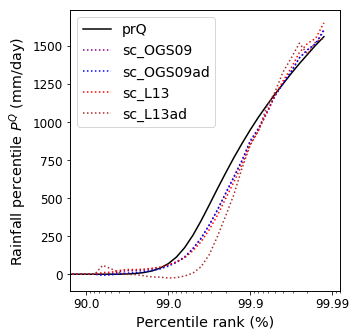

In [42]:
print("Show scalings")

fig,ax = plt.subplots(ncols=1,figsize=(5,5))

x = np.flipud(1./(1-ranks_ref[:-1]/100.))
addZeroLine(ax,x,alpha=0)

subplotRanksILog(ax,ranks_ref,
                 [pr_scalings['prQ'],
                  pr_scalings['sc_OGS09']*86400,
                  pr_scalings['sc_OGS09ad']*86400,
                  pr_scalings['sc_L13']*86400,
                  pr_scalings['sc_L13ad']*86400],
                 col=['k','purple','b','red','brown'],
                 ltype=['-',':',':',':',':'],
                 labels=['prQ','sc_OGS09','sc_OGS09ad','sc_L13','sc_L13ad'],
                 transformX=True)

ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Rainfall percentile $P^Q$ (mm/day)')

# Crop x-axis
iQ_min = 8
x = np.flipud(1./(1-ranks_ref/100.))
ax.set_xlim((x[iQ_min-1],0.8))

In [ ]:
print("Save coefficients and individual components ")

## Plot fracchanges in $P$, $P_{sc}$ and each contrib

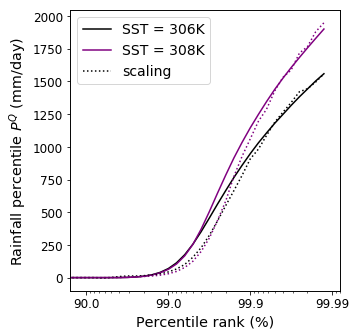

In [76]:
s = sQ
# s = sQ99999

fig,ax = plt.subplots(ncols=1,figsize=(5,5))
# ax.set_ylim((-5,20))

x = np.flipud(1./(1-ranks_ref[:-1]/100.))
addZeroLine(ax,x,alpha=0)

subplotRanksILog(ax,ranks_ref,
                 [pr_sc_all['prQ_cold'],pr_sc_all['prQ_warm'],
                  pr_sc_all['alpha_cold']*pr_sc_all['cold']*86400,
                  pr_sc_all['alpha_warm']*pr_sc_all['warm']*86400],
                 col=['k','purple','k','purple'],
                 ltype=['-','-',':',':'],
                 labels=['SST = %dK'%SSTs[0],'SST = %dK'%SSTs[1],'scaling',''],
                 transformX=True)

ax.legend(loc='best',fontsize=14)
ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Rainfall percentile $P^Q$ (mm/day)')

# Crop x-axis
iQ_min = 8
x = np.flipud(1./(1-ranks_ref/100.))
ax.set_xlim((x[iQ_min-1],0.8))

plt.savefig(os.path.join(figuredir,'percentiles_and_scaling_%s_%s.pdf'%(expnames[SSTs[0]],expnames[SSTs[1]])),
            bbox_layout='tight')
plt.show()

prQ
scaling
alpha
dynamic
thermodynamic
pressure
residual


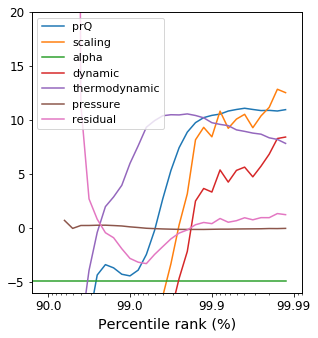

In [77]:
## For each experiment, plot all of the above

# simnames_agg_disagg_warming = \
# 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1',\
# 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1',\
# 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1',\
# 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1'

# c = ['k','k','purple','purple']
# lt = ['-','--','-','--']
# labs = [r'$\mathcal{D}$, 300K',\
#         '$\mathcal{O}$, 300K',\
#         '$\mathcal{D}$, 304K',\
#         '$\mathcal{O}$, 304K']

s = sQ
# s = sQ99999

fig,ax = plt.subplots(ncols=1,figsize=(5,5))
ax.set_ylim((-6,20))

x = np.flipud(1./(1-ranks_ref[:-1]/100.))
addZeroLine(ax,x,alpha=0)

for ic in range(len(contributions)):

    contribution = contributions[ic]
    print(contribution)
    fccontrib = fracChanges[contribution]
    if fccontrib.__class__ == np.float64:
        fccontrib = fccontrib*np.ones(ranks_ref.shape)

    subplotRanksILog(ax,ranks_ref,
                     fccontrib,
#                      col=c[i],
#                      ltype=lt[i],
                     labels=contribution,
                     transformX=ic==len(contributions)-1)

ax.legend(loc='best',fontsize=11)
ax.set_xlabel('Percentile rank (%)')
# ax.set_ylabel(r'Rainfall percentile $P^Q$ (mm/day)')

# Crop x-axis
iQ_min = 8
x = np.flipud(1./(1-ranks_ref/100.))
ax.set_xlim((x[iQ_min-1],0.8))

plt.savefig(os.path.join(figuredir,'percentiles_org_disorg_300_304.pdf'),
            bbox_layout='tight')
plt.show()

In [78]:
## What matters overall, for organized vs. disorganized?
## Plot that specifically

In [79]:
## Dig into aggregated experiments with different surface forcings

In [80]:
## Dig into aggregated experiments with different shallow convective mixing